In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
Nmeasures = 1000

def dati(k):
    #fname=f'data/MockMeasures_2PCF_Test1/MockMeasures_2PCF_Correlation_MULTIPOLES_Test1_{k+1}.fits'
    #file = fits.open(fname)

    bins=200 #lunghezza vettore
    Nmeasures = 1000 #misure, facciamo prime dieci
    test = k+1
    measures0 = []
    measures2 = []
    measures4 = []

    for i in np.arange(Nmeasures)+1:
        fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
        # f all'inizio permette di sostituire {test} con il rispettivo valore
        # print(f'apro il file numero {i} chiamato {fname}')

        file = fits.open(fname)
        table = file[1].data.copy()
        measures0.append(table['XI0']) #XI2 e XI4 sono gli altri multipoli
        measures2.append(table['XI2'])
        measures4.append(table['XI4'])
        if i==1:
            scale = table['SCALE'] #estrae la colonna scale, una sola volta, è sempre la stessa
        del table    #cancella tabella, non serve più
        file.close()

    measures0 = np.asarray(measures0)
    measures2 = np.asarray(measures2)
    measures4 = np.asarray(measures4)
    measures = np.concatenate((measures0.transpose(),measures2.transpose(),measures4.transpose()))

    sigma = [[0.02,0.02,0.02],[0.02,0.01,0.005],[0.02,0.01,0.005]]
    h = [[25,50,75],[50,50,50],[5,5,5]]
    return measures, sigma[k], h[k], scale

In [10]:
n=600

# covarianza misurata
def covarianza(i,j):
    cov = 0
    for n in range(Nmeasures):
        cov += (measures[n,i] - np.mean(measures[:,i]))*(measures[n,j] - np.mean(measures[:,j]))
    cov = cov/(Nmeasures-1)
    return cov

# coefficiente di correlazione
def corr_coef(cov,i,j):
    return cov[i,j]/(cov[i,i]*cov[j,j])**0.5

# covarianza teorica
def cov_exp(r,i,j):
    l1 = int(i/200)
    l2 = int(j/200)
    return sigma[l1]*sigma[l2]*np.sqrt(2*h[l1]*h[l2]/(h[l1]**2+h[l2]**2))*np.exp(-(r[i%200]-r[j%200])**2/(h[l1]**2+h[l2]**2))

# residui
def res(ct,cm,cr,i,j):
    return (ct[i,j]-cm[i,j])*np.sqrt((Nmeasures-1)/((1+cr[i,j])*ct[i,i]*ct[j,j]))

# matrice correlazioni
def cor(covm):
    cor = np.zeros((n,n),dtype=float)
    for l in range(1,4):
        for k in range(1,4):
            for i in range((l-1)*200,l*200):
                for j in range((k-1)*200,k*200):
                    cor[i,j] = corr_coef(covm,i,j)
    return cor

# matrice covarianza teorica
def cot(scale):
    covt = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            covt[i,j] = cov_exp(scale,i,j)
    return covt

# matrice residui
def rsd(covt,covm,corr):
    resi = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            resi[i,j] = res(covt,covm,corr,i,j)
    return resi

def plotter(M,tit):
    fig = plt.figure(layout='constrained')
    ax = fig.add_subplot()
    #cax = ax.matshow(M, cmap=plt.cm.get_cmap('cividis', ), interpolation='nearest')
    cax = ax.imshow(M)
    fig.colorbar(cax)
    ax.set_title(tit, size=20)
    plt.savefig(tit+'.pdf', bbox_inches='tight')


rms deviation of normalized residuals: 0.7117417288815875
**********
* PASSED *
**********
rms deviation of normalized residuals: 0.7261028806483506
**********
* PASSED *
**********
rms deviation of normalized residuals: 1.0317627201555333
**********
* PASSED *
**********


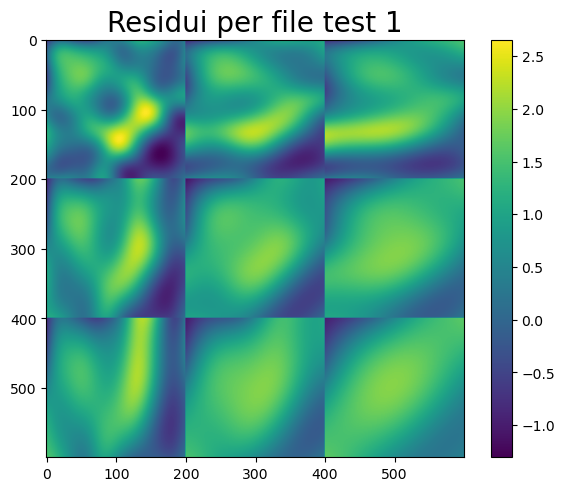

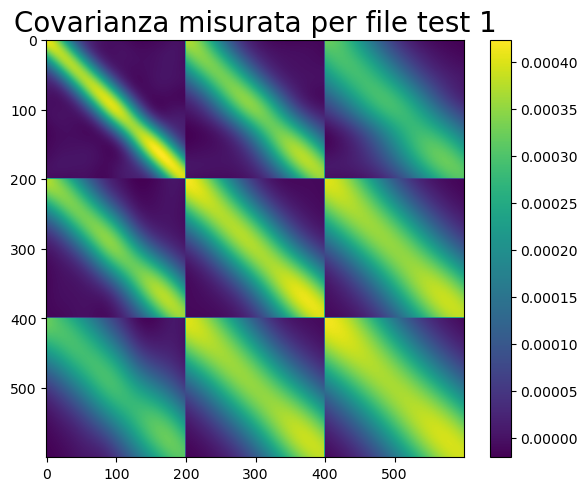

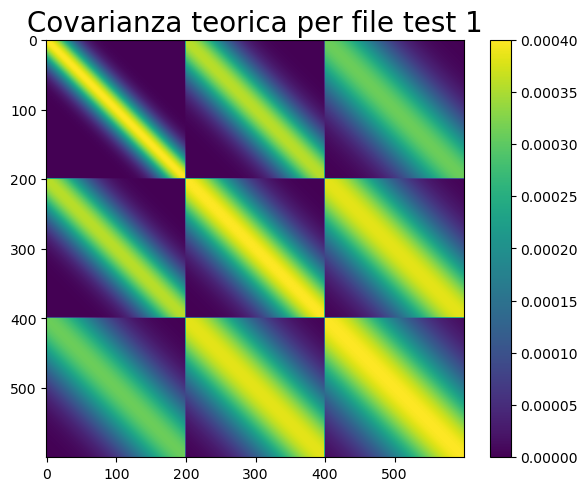

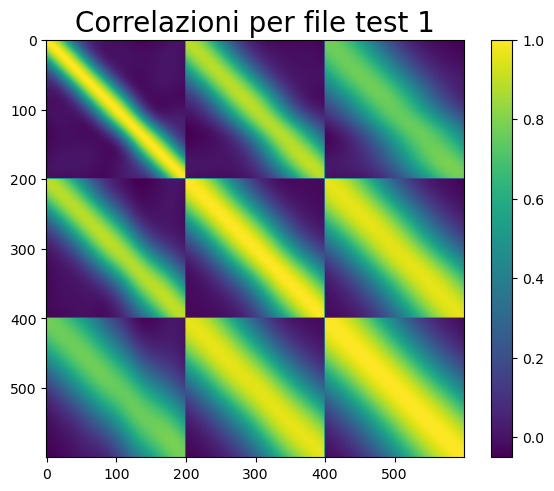

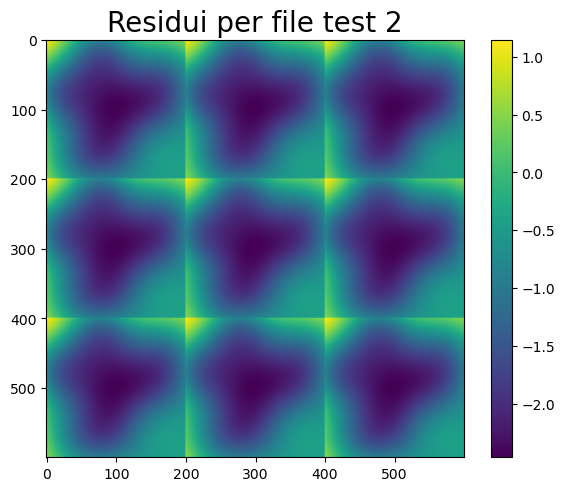

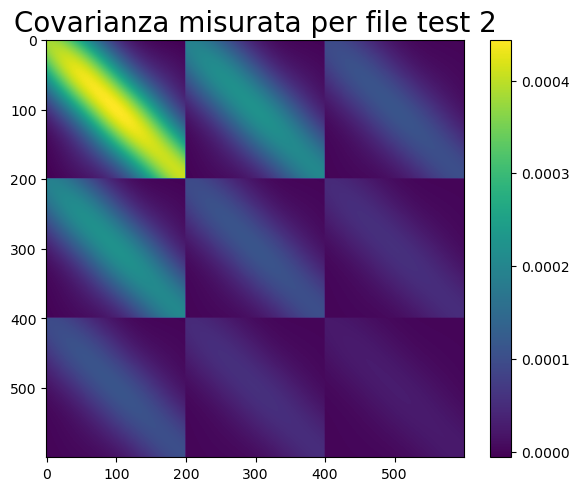

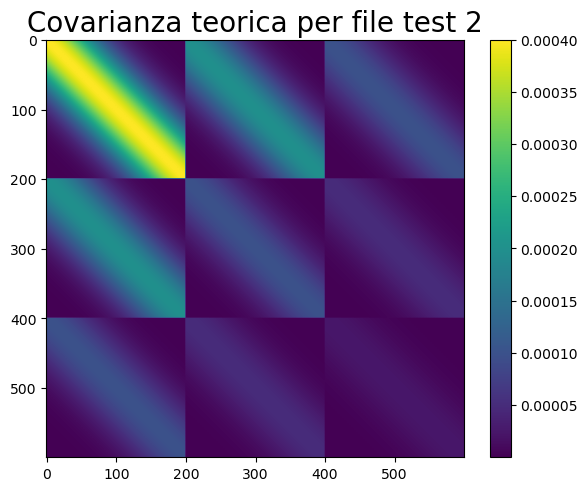

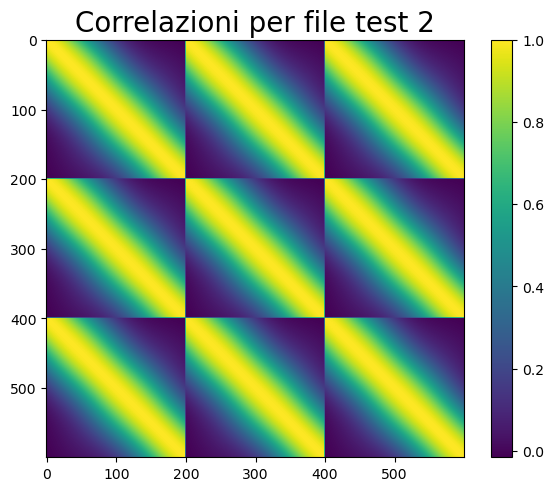

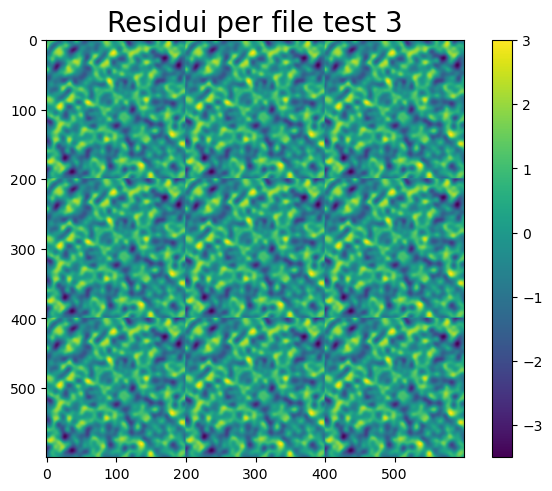

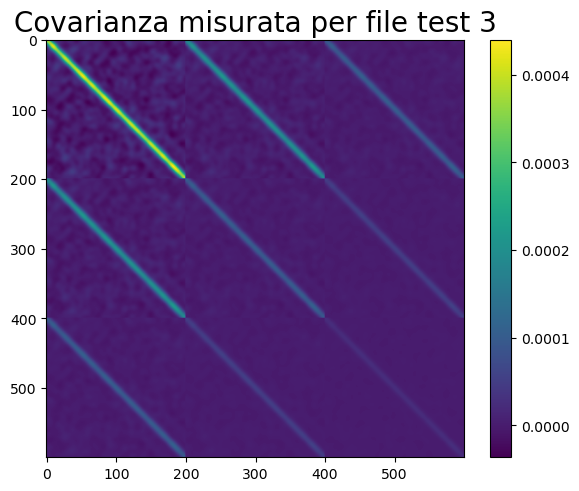

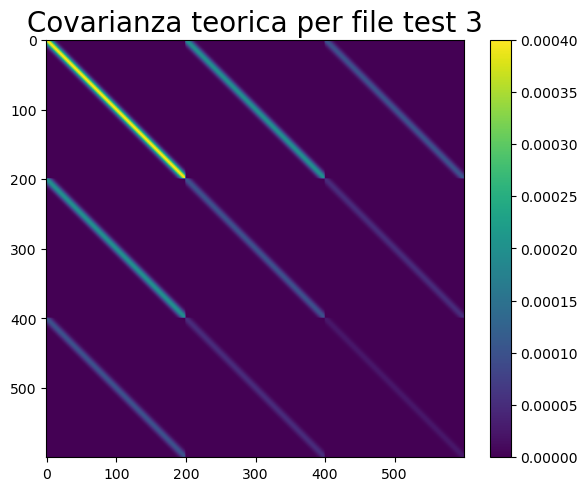

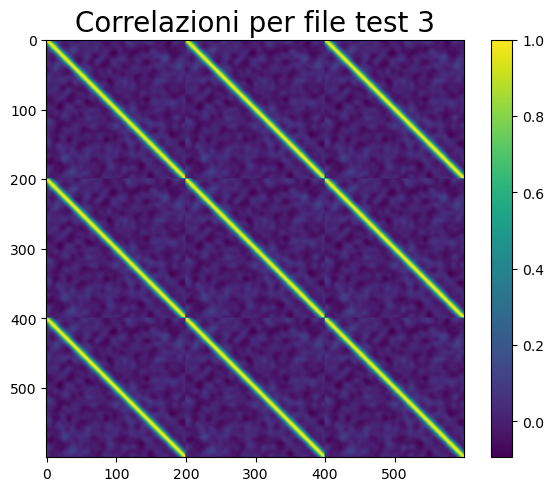

In [11]:
for k in range(3):
    measures, sigma, h, scale = dati(k)
    covm = np.cov(measures)
    corr = cor(covm)
    covt = cot(scale)
    resi = rsd(covt,covm,corr)
    plotter(resi,f'Residui per file test {k+1}')
    plotter(covm,f'Covarianza misurata per file test {k+1}')
    plotter(covt,f'Covarianza teorica per file test {k+1}')
    plotter(corr,f'Correlazioni per file test {k+1}')
    rms_deviation=np.std(resi)

    print(f"rms deviation of normalized residuals: {rms_deviation}")

    if rms_deviation<1.1:
        print("**********")
        print("* PASSED *")
        print("**********")
    else:
        print("!!!!!!!!!!")
        print("! FAILED !")
        print("!!!!!!!!!!")